# Loeppky (2013) test function

We perform adaptive sampling on the Loeppky (2013) test function [1]:

$f({\bf x}) = 6x_1 + 4x_2 + 5.5x_3 + 3x_1x_2 + 2.2x_1x_2 + 1.4x_2x_3 + x_4+ 0.5x_5 + 0.2x_6 + 0.1x_7$

[1] Loeppky, J. L., Williams, B. J., & Moore, L. M. (2013). Global sensitivity analysis for mixture experiments. Technometrics, 55(1), 68-78.

Description, quoted from www.sfu.ca/~ssurjano/loepetal13.html:

**Dimensions: 10**

"*This function is designed for sensitivity analysis, such that the first three input variables are highly sensitive, and the last three are insensitive, while the rest are moderately sensitive (Loeppky et al., 2013). For this reason, the last three input variables do not appear in the expression.*"

All 10 inputs are uniformly distributed: $x_i\sim\mathcal{U}[0, 1]$, $i=1\cdots,10$.

Author: Wouter Edeling, CWI Scientific Computing Group (Wouter.Edeling@CWI.nl)

## Installation

* EasyVVUQ: via git clone or by executing the command below


In [1]:
#!pip install easyvvuq

In [2]:
import os
import numpy as np
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions

### Setting up an EasyVVUQ campaign

We first set up the `params` dictionary, in which we specify the name, type and default value of each input:

In [3]:
# number of inputs
d = 10

# params dict
params = {}
for i in range(d):
    params['x%d' % (i + 1)] = {'type': 'float', 'default': 0.5}

params

{'x1': {'type': 'float', 'default': 0.5},
 'x2': {'type': 'float', 'default': 0.5},
 'x3': {'type': 'float', 'default': 0.5},
 'x4': {'type': 'float', 'default': 0.5},
 'x5': {'type': 'float', 'default': 0.5},
 'x6': {'type': 'float', 'default': 0.5},
 'x7': {'type': 'float', 'default': 0.5},
 'x8': {'type': 'float', 'default': 0.5},
 'x9': {'type': 'float', 'default': 0.5},
 'x10': {'type': 'float', 'default': 0.5}}

Next we'll set up the **encoder**, which will create the input files for the model using an input template. In this case the input file is just a comma-separated file of values. To create an EasyVVUQ input template each value is replaced by `$param_name`:

`$x1,$x2,$x3,$x4,$x5,$x6,$x7,$x8,$x9,$x10`

The encoder will swap out the `$param_name` flags for values drawn from the specified input distribution.

In [4]:
# input file encoder
encoder = uq.encoders.GenericEncoder(template_fname='loeppky.template', delimiter='$', target_filename='input.csv')

The model writes a CSV file `output.csv` containing the prediction $f({\bf x})$. The **decoder** will read this file and store its contents within the EasyVVUQ database. 

In [5]:
# Quantity of Interest, also the column name of the output CSV file
QOI = 'f'
# CSV output file decoder
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', output_columns=[QOI])

We'll run the ensemble locally. However, in many cases of practical interest the model will be too expensive for local execution. In this case the VECMA tools [QCG-PilotJob](https://github.com/vecma-project/QCG-PilotJob) or [FabSim3](https://github.com/djgroen/FabSim3) can be used in combination with EasyVVUQ to submit the ensemble to HPC resources.

In [6]:
# local execution of HIV_model.py
execute = ExecuteLocal('{}/loeppky.py'.format(os.getcwd()))

Now we are combine all actions we want to execute into an `Actions` object.

In [7]:
# location where the run directories are stored
WORK_DIR = '/tmp'
# actions to be undertaken: make rundirs, encode input files, execute local model ensemble, decode output files
actions = Actions(CreateRunDirectory(root=WORK_DIR, flatten=True), Encode(encoder), execute, 
                  Decode(decoder))

The central object in the UQ analysis is a so-called Campaign. This is created as:

In [8]:
campaign = uq.Campaign(name='loeppky', params=params, actions=actions, work_dir=WORK_DIR)

We do redefine `vary`, as we will include all `D` inputs in the uncertainty analysis this time.

In [9]:
vary = {}
for i in range(d):
    vary['x%d' % (i + 1)] = cp.Uniform(0, 1)

We now select the adaptive Stochastic Collocation sampler. Here

* `polynomial_order = 1`: should be interpreted in the sparse context as starting the sampling plan with a level 1 quadrature rule for all inputs.
* `quadrature_rule='C'`: selects the Clenshaw Curtis quadrature rule.
* `sparse=True`: selects the sparse grid.
* `growth=True`: selects an exponential growth rule which makes the Clenshaw Curtis rule nested.
* `dimension_adaptive=True`: selects the dimension-adaptive sampler.

In [10]:
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=1, quadrature_rule='C', sparse=True,
                                growth=True, dimension_adaptive=True)
campaign.set_sampler(sampler)

Run the first ensemble, which consists of just a single sample:

In [11]:
campaign.execute().collate(progress_bar=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


To analyse the results (and execute the dimension adaptivity), we need an `SCAnalysis` object:

In [12]:
analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=[QOI])
# perform analysis (basically estimates moments, Sobol analysis, and updates internal state of analysis)
campaign.apply_analysis(analysis)

/home/wouter/.local/lib/python3.7/site-packages/easyvvuq-1.1.2-py3.7.egg/easyvvuq/analysis/sc_analysis.py:1118: RuntimeWarning: invalid value encountered in true_divide
  S_u[u] = D_u[u] / D


Now we'll refine the grid several times in an anisotropic fashion. Here

* `look_ahead`: determines the new admissible candidate refinements.
* `campaign.get_collation_result()`: get the data frame with all code samples.
* `adapt_dimension`: compute the hierarchical surplus at all candidate refinements, and accept the one with the highest surplus.

In [13]:
number_of_adaptations = 11
for i in range(number_of_adaptations):
    # compute candidate refinements
    sampler.look_ahead(analysis.l_norm)
    # run ensemble (at new locations only)
    campaign.execute().collate(progress_bar=True)
    # get data frame
    data_frame = campaign.get_collation_result()
    # adapt the sampling plan
    analysis.adapt_dimension(QOI, data_frame)
    # we must apply the analysis to update its internal state
    campaign.apply_analysis(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.80it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 27.04it/s]


This command retrieves the result after all refinements:

In [14]:
results = campaign.get_last_analysis()

The `adaptation_table` shows a plot of that visualizes which inputs got refined.

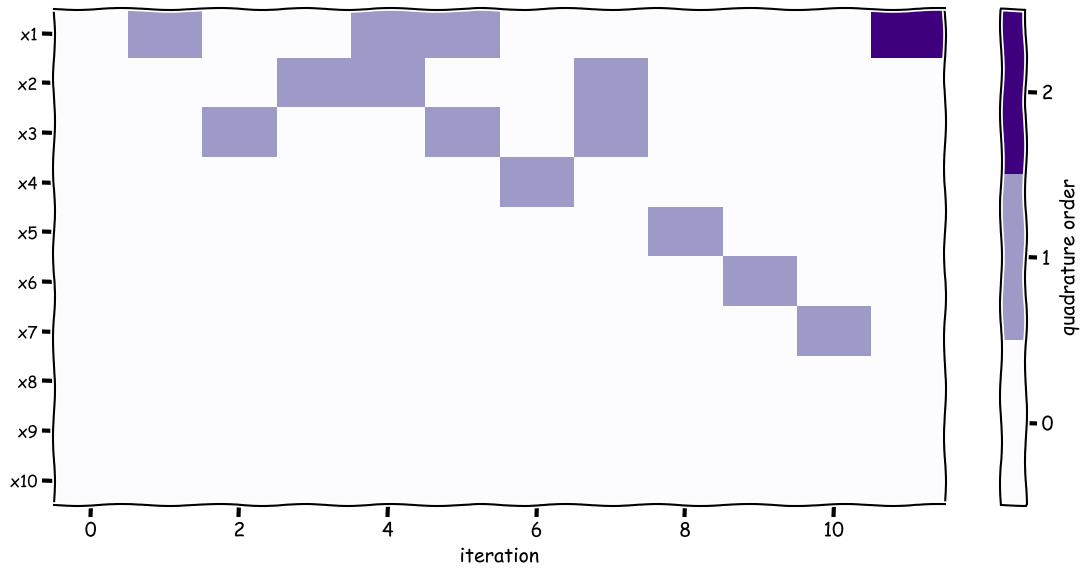

In [15]:
with plt.xkcd():
    analysis.adaptation_table()

Since we are dealing with a polynomial test function, the SC approximation should be exact after sufficient iterations. In this case this happens after 10 iterations, and iteration 11 shown above does not improve the surrogate model further. This case be seen by examining the hierarchical surplus error values that were used to accept the multi indices into $\Lambda$. Note that the last two errors are essentially zero:

In [16]:
print(analysis.get_adaptation_errors())

[4.3, 3.6500000000000004, 3.1, 0.7500000000000001, 0.5499999999999993, 0.5, 0.34999999999999953, 0.25, 0.09999999999999964, 0.04999999999999982, 7.549516567451064e-15]


In [17]:
def loeppky(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    x5 = x[4]
    x6 = x[5]
    x7 = x[6]

    term1 = 6*x1 + 4*x2
    term2 = 5.5*x3 + 3*x1*x2
    term3 = 2.2*x1*x3 + 1.4*x2*x3
    term4 = x4 + 0.5*x5
    term5 = 0.2*x6 + 0.1*x7

    return term1 + term2 + term3 + term4 + term5

In [18]:
def get_confidence_intervals(samples, conf=0.9):
    """
    Compute the confidence intervals given an array of samples

    Parameters
    ----------
    samples : array
        Samples on which to compute the intervals.
    conf : float, optional, must be in [0, 1].
        The confidence interval percentage. The default is 0.9.

    Returns
    -------
    lower : array
        The lower confidence bound..
    upper : array
        The upper confidence bound.

    """

    # ake sure conf is in [0, 1]
    if conf < 0.0 or conf > 1.0:
        print('conf must be specified within [0, 1]')
        return

    # lower bound = alpha, upper bound = 1 - alpha
    alpha = 0.5 * (1.0 - conf)

    # arrays for lower and upper bound of the interval
    n_samples = samples.shape[0]
    N_qoi = samples.shape[1]
    lower = np.zeros(N_qoi)
    upper = np.zeros(N_qoi)

    # the probabilities of the ecdf
    prob = np.linspace(0, 1, n_samples)
    # the closest locations in prob that correspond to the interval bounds
    idx0 = np.where(prob <= alpha)[0][-1]
    idx1 = np.where(prob <= 1.0 - alpha)[0][-1]

    # for every location of qoi compute the ecdf-based confidence interval
    for i in range(N_qoi):
        # the sorted surrogate samples at the current location
        samples_sorted = np.sort(samples[:, i])
        # the corresponding confidence interval
        lower[i] = samples_sorted[idx0]
        upper[i] = samples_sorted[idx1]

    return lower, upper

In [19]:
n_mc = [10, 100, 1000, 10000]
n_replica = 100
mean_mc = np.zeros([len(n_mc), n_replica])
std_mc = np.zeros([len(n_mc), n_replica])

mean_SC = results.describe(QOI, 'mean')
std_SC = results.describe(QOI, 'std')

for idx, n_samples in enumerate(n_mc):
    for replica in range(n_replica):
        inputs = np.array([param.sample(n_samples) for param in vary.values()])
        samples = loeppky(inputs)
        mean_mc[idx, replica] = np.mean(samples)
        std_mc[idx, replica] = np.std(samples)

lower, upper = get_confidence_intervals(mean_mc.T)
yerr_mean = np.array([np.mean(mean_mc, axis=1) - lower, upper - np.mean(mean_mc, axis=1)])

lower, upper = get_confidence_intervals(std_mc.T)
yerr_std = np.array([np.mean(std_mc, axis=1) - lower, upper - np.mean(std_mc, axis=1)])

with plt.xkcd():
    fig = plt.figure(figsize=[8,4])
    ax = fig.add_subplot(121, xscale='log', xlabel='model evaluations', ylabel='mean')
    ax.errorbar(n_mc, np.mean(mean_mc, axis=1), yerr=yerr_mean, fmt='o', label='MC with 90% CI')
    ax.plot(np.cumsum(sampler.n_new_points), analysis.mean_history, '*', color='salmon', zorder=3, label='SC')
    plt.legend(frameon=False)

    ax = fig.add_subplot(122, xscale='log', xlabel='model evaluations', ylabel='standard deviation')
    ax.errorbar(n_mc, np.mean(std_mc, axis=1), yerr=yerr_std, fmt='o')
    ax.plot(np.cumsum(sampler.n_new_points), analysis.std_history, '*', color='salmon', zorder=3)
    plt.tight_layout()

Finally, we will create a plot with all first-order Sobol indices `S_i`, which shows the fraction of the output variance, that each input variable is responsible for *by itself*. To also estimate higher-order effects (the fraction of variance obtained by simultaneously varying 2 or more inputs together), we sum all first-order indices (shown in the first bar). Where this sum is close to one, there are (almost) no higher-order effects.

In [20]:
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_subplot(111, title=r'First-order Sobol indices', ylim=[0,1])
    ax.set_ylabel(r'$S_i$', fontsize=14)
    sobols_first = np.array(list(results.sobols_first(QOI).values()))
    ax.bar(0, np.sum(sobols_first), color='salmon')
    ax.bar(np.arange(1, d+1), sobols_first.flatten(), color='dodgerblue')
    labels = ['total first order']
    for i in range(d): labels.append('x%d' % (i+1))
    ax.set_xticks(np.arange(d+1))
    ax.set_xticklabels(labels, rotation=90)